In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 0)

import sys
sys.path.append('../')

import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm
tqdm.pandas()

from utils import *

In [3]:
NAME = 'v3'

In [18]:
X_train = pd.read_feather('../working/X_train.ftr')
y_train = pd.read_feather('../working/y_train.ftr').TARGET
X_test = pd.read_feather('../working/X_test.ftr')

In [19]:
X_train.drop(['before_employ',
       'before_register', 'before_id_publish', 'credit_income_ratio',
       'goods_income_ratio', 'annuity_income_ratio', 'goods_credit_ratio',
       'n_divisio', ],axis=1, inplace=True)
X_test.drop(['before_employ',
       'before_register', 'before_id_publish', 'credit_income_ratio',
       'goods_income_ratio', 'annuity_income_ratio', 'goods_credit_ratio',
       'n_division', ],axis=1, inplace=True)

In [21]:
X_train.to_feather(WORKING / 'basic_train.ftr')
X_test.to_feather(WORKING / 'basic_test.ftr')

In [7]:
X_train.filter(regex='[a-z]').columns

Index(['AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'HOUR_APPR_PROCESS_START_x', 'main_null_cnt', 'before_employ',
       'before_register', 'before_id_publish', 'credit_income_ratio',
       'goods_income_ratio', 'annuity_income_ratio', 'goods_credit_ratio',
       'n_divisio', 'MONTHS_BALANCE_x', 'SK_DPD_x', 'SK_DPD_DEF_x',
       'pos_null_cnt', 'pos_status_nunique', 'pos_count', 'MONTHS_BALANCE_y',
       'SK_DPD_y', 'SK_DPD_DEF_y', 'card_null_cnt', 'card_status_nunique',
       'card_count', 'AMT_ANNUITY_y', 'bureau_null_cnt',
       'nunique_CREDIT_ACTIVE', 'nunique_CREDIT_CURRENCY',
       'nunique_CREDIT_TYPE', 'bureau_count', 'AMT_CREDIT_y',
       'AMT_GOODS_PRICE_y', 'HOUR_APPR_PROCESS_START_y', 'previous_null_cnt',
       'nunique_NAME_CONTRACT_TYPE', 'nunique_WEEKDAY_APPR_PROCESS_START',
       'nunique_NAME_CASH_LOAN_PURPOSE', 'nunique_NAME_CONTRACT_STATUS',
       'nunique_NAME_PAYMENT_TYPE', 'nunique_CODE_REJECT_REASON',
       'nunique_NAME_TYPE_SUITE',

In [5]:
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

In [11]:
cv = StratifiedKFold(5, shuffle=True, random_state=77)

In [6]:
lgb_params = {
    'n_estimators'     : 4000,
    'learning_rate'    : 0.1,
    'num_leaves'       : 31,
    'colsample_bytree' : 0.8,
    'subsample'        : 0.9,
    'reg_alpha'        : 0.1,
    'reg_lambda'       : 0.1,
    'min_split_gain'   : 0.01,
    'min_child_weight' : 2,
    'random_state': 77
}

In [25]:
score = cross_validate(lgb.LGBMClassifier(**lgb_params), X_train, y_train, cv=cv.split(X_train, y_train), scoring='roc_auc', n_jobs=3, verbose=4)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.7710112500006903, total= 6.6min
[CV] ....................... , score=0.7718477964378829, total= 6.6min
[CV] ....................... , score=0.7719543855469814, total= 6.6min
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  7.4min remaining: 11.1min


[CV]  ................................................................
[CV] ....................... , score=0.7754432289802786, total= 4.1min
[CV] ....................... , score=0.7744618221032912, total= 4.2min


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 11.9min finished


In [26]:
valid_score = score['test_score'].mean()
print(valid_score)

0.7729436966138249


In [7]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=2, min_split_gain=0.01, n_estimators=4000,
        n_jobs=-1, num_leaves=31, objective=None, random_state=77,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1)

In [8]:
print('lgb_params =', lgb_params)

lgb_params = {'n_estimators': 4000, 'learning_rate': 0.1, 'num_leaves': 31, 'colsample_bytree': 0.8, 'subsample': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'min_split_gain': 0.01, 'min_child_weight': 2, 'random_state': 77}


In [10]:
del generate_submit
from utils import generate_submit

In [12]:
sub = pd.read_feather(INPUT/'sample_submission.ftr')
sub.TARGET = model.predict_proba(X_test)[:, 1]
filename = OUTPUT / f"{time.strftime('%y%m%d_%H%M%S')}_{NAME}.csv.gz"
print(f'output {filename}')
sub.to_csv(filename, index=None, compression='gzip')

output ../output/180523_205221_v3.csv.gz


In [11]:
generate_submit(model.predict_proba(X_test)[:, 1], f'{NAME}')

load sample submit


TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

In [ ]:
feat_df = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns).sort_values('importance')
feat_df[-50:].plot.barh(figsize=(20, 15))
plt.savefig(str(Path().home()/f'Dropbox/kaggle/{NAME}_feats.pdf'))
plt.show()

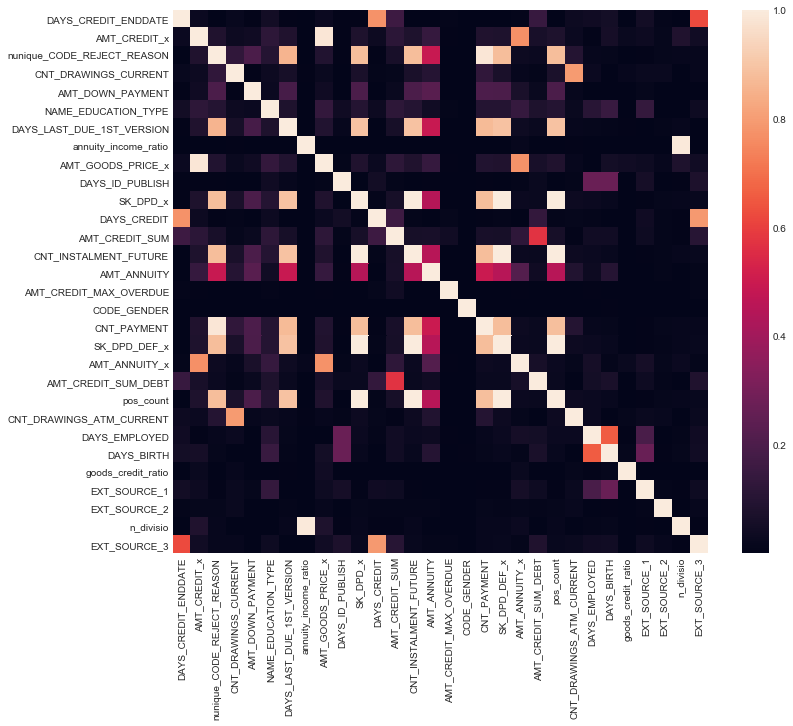

In [62]:
plt.figure(figsize=(12, 10))
sns.heatmap(abs(X_train[feat_df[-30:].index].corr()))
plt.show()